## Краткое описание проекта и расшифровка столбцов

Из банка стали уходить клиенты. Немного, но заметно. Из расчетов известно, что сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдет клиент из банка в ближайшее время или нет. Представлены исторические данные о поведении клиентов и расторжении договоров с банком.

Расшифровка названий столбцов:

**Признаки**


* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Целевой признак**

* Exited — факт ухода клиента

Выполним обновление существующих библиотек и установку отсутствующих

In [1]:
!pip install scikit-learn -U
!pip install seaborn -U
!pip install hyperopt

Requirement already up-to-date: scikit-learn in c:\users\atrus\anaconda3\lib\site-packages (1.0.1)
Requirement already up-to-date: seaborn in c:\users\atrus\anaconda3\lib\site-packages (0.11.2)


Выполним импорт библиотек, которые будем использовать в работе

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.compose import ColumnTransformer

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 100)

sns.set(style="darkgrid")

## Загрузка данных и просмотр

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
display(df)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1.000,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8.000,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.000,125510.820,1,1,1,79084.100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.000,0.000,2,1,0,96270.640,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.000,57369.610,1,1,1,101699.770,0
9997,9998,15584532,Liu,709,France,Female,36,7.000,0.000,1,0,1,42085.580,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.000,75075.310,2,1,0,92888.520,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.isna().mean()

RowNumber         0.000
CustomerId        0.000
Surname           0.000
CreditScore       0.000
Geography         0.000
Gender            0.000
Age               0.000
Tenure            0.091
Balance           0.000
NumOfProducts     0.000
HasCrCard         0.000
IsActiveMember    0.000
EstimatedSalary   0.000
Exited            0.000
dtype: float64

В `Tenure` пропуски составляют 9 процентов.

In [6]:
df.duplicated().sum()

0

Дубликатов в данных нет

In [7]:
df.nunique().sort_values()

Gender                 2
HasCrCard              2
IsActiveMember         2
Exited                 2
Geography              3
NumOfProducts          4
Tenure                11
Age                   70
CreditScore          460
Surname             2932
Balance             6382
EstimatedSalary     9999
RowNumber          10000
CustomerId         10000
dtype: int64

Среди номеров строк и ID повторений также нет, все значения уникальны.

Удалим следующие столбцы, так как для обучения модели они никак не пригодятся: `CustomerId`, `RowNumber`, `Surname`.

In [8]:
df = df.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Посмотрим, как распределены пропуски в данных между клиентами из разных стран по половому признаку

In [10]:
t_nans = df[df['Tenure'].isna()].groupby(['Geography', 'Gender'])['Exited'].count().reset_index()
t_all = df.groupby(['Geography', 'Gender'])['Exited'].count().reset_index()
t = pd.merge(t_nans, t_all, on=['Geography', 'Gender'])
t['ratio'] = t['Exited_x'] / t['Exited_y']
display(t)

,Geography,Gender,Exited_x,Exited_y,ratio
0,France,Female,217,2261,0.096
1,France,Male,247,2753,0.090
2,Germany,Female,108,1193,0.091
3,Germany,Male,108,1316,0.082
4,Spain,Female,101,1089,0.093
5,Spain,Male,128,1388,0.092


Пропуски распределены равномерно (примерно в одинаковом соотношении) по группам.

In [11]:
df['Exited'].mean()

0.2037

In [12]:
df[df['Tenure'].isna()]['Exited'].mean()

0.20132013201320131

Баланс классов у пропусков примерно такой же как в датасете.

Определим категориальные и численные переменные

In [13]:
cat_columns = ['Gender',
               'HasCrCard',
               'IsActiveMember',
               'Geography',
               'NumOfProducts',
               'Tenure'
]

num_columns = ['Age',
               'CreditScore',
               'Balance',
               'EstimatedSalary',
]

In [14]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,10000.000,9091.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,650.529,38.922,4.998,76485.889,1.530,0.706,0.515,100090.240,0.204
std,96.653,10.488,2.895,62397.405,0.582,0.456,0.500,57510.493,0.403
min,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,584.000,32.000,2.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.247,0.000
max,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000


### Обработка пропусков

В данных есть пропуски, которые заполним самым популярным значением (модой) по группе. Предварительно дополнительно добавим группу с градацией по возрасту. Разделим на 5 примерно равных по количеству людей групп.

In [15]:
df['AgeGroup'] = pd.qcut(df['Age'], 5)
display(df['AgeGroup'].value_counts().sort_index())

(17.999, 31.0]    2372
(31.0, 35.0]      1781
(35.0, 40.0]      2266
(40.0, 46.0]      1696
(46.0, 92.0]      1885
Name: AgeGroup, dtype: int64

Дополнительные группы созданы, теперь заполним пропуски

In [16]:
df['Tenure'] = df.groupby(
        ['Geography',
         'Gender',
         'AgeGroup']
)['Tenure'].transform(lambda x: x.fillna(x.mode()[0]))

In [17]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,650.529,38.922,4.923,76485.889,1.530,0.706,0.515,100090.240,0.204
std,96.653,10.488,2.895,62397.405,0.582,0.456,0.500,57510.493,0.403
min,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,584.000,32.000,2.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.247,0.000
max,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000


Пропуски заполнены, теперь изменим тип данных и удалим столбец `AgeGroup`

In [18]:
df['Tenure'] = df['Tenure'].astype('int')

In [19]:
df = df.drop('AgeGroup', axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int32  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 820.4+ KB


Выходцы из каких стран чаще покидают банк?

<AxesSubplot:xlabel='Geography'>

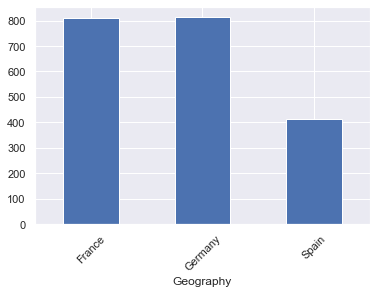

In [21]:
(df[df['Exited'] == 1].groupby(['Geography'])['Exited'].count()).plot(kind='bar', rot=45)

Какие клиенты богаче на момент выхода?

Text(0.5, 1.0, 'Баланс на момент выхода')

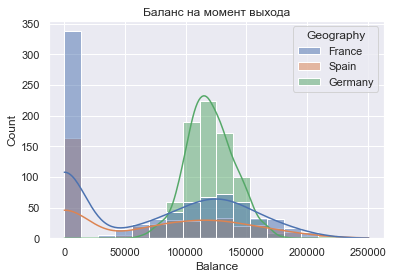

In [22]:
sns.histplot(data=df[df['Exited'] == 1], x='Balance', kde=True, hue='Geography')

plt.title('Баланс на момент выхода')

Text(0.5, 1.0, 'Возраст клиентов на момент выхода')

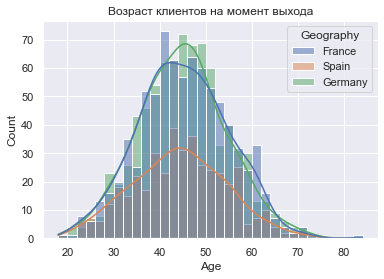

In [23]:
sns.histplot(data=df[df['Exited'] == 1], x='Age', kde=True, hue='Geography')

plt.title('Возраст клиентов на момент выхода')

Text(0.5, 1.0, 'Количество продуктов на момент выхода')

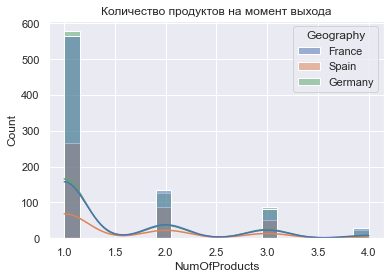

In [24]:
sns.histplot(data=df[df['Exited'] == 1], x='NumOfProducts', kde=True, hue='Geography')

plt.title('Количество продуктов на момент выхода')

Text(0.5, 1.0, 'Сколько лет был клиентом банка')

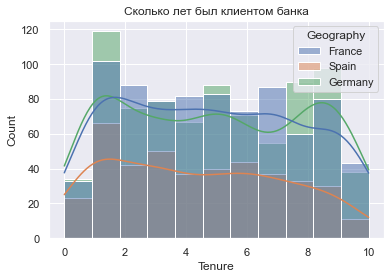

In [25]:
sns.histplot(data=df[df['Exited'] == 1], x='Tenure', kde=True, hue='Geography', bins=11)

plt.title('Сколько лет был клиентом банка')

### Выводы

В данных присустсвуют пропуски, которые было решено заполнить самым популярным значением по группе. Не сбалансирован целевой признак (20/80), а также не сбалансированы предикторные переменные.

Интересно, что:
* В данных больше всего клиентов из Франции 50%, а из Германии и Испании - поровну (25% и 25%); 
* При этом покинуло больше всего банк клиентов из Германии и Франции, а из Испании в 2 раза меньше;

## Исследование задачи

### Подготовка

Разделим данные на обучающую выборку и тестовую.

In [26]:
X, y = df.drop('Exited', axis=1).copy(), df['Exited'].copy()

In [27]:
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, stratify=y,
                 random_state=420, shuffle=True)

In [28]:
print(y_train.mean())
print(y_test.mean())

0.20373333333333332
0.2036


Баланс классов целевой переменной для тренировочной, валидационной и тестовой выборок такой же, как и у исходной выборки.
Произведем обучение, в качестве метрики зададим F1, дополнительно будем отслеживать ROC-AUC.

В начале произведем обработку всех переменных, используя пайплайн. Для категориальных признаков будем использовать One Hot Encoding (далее OHE), а для численных - масштабирование (Standerd Scaler). При этом для избежания дамми-ловушки будем удалять первый столбец для бинарных переменных.

In [29]:
cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False, 
                        drop='if_binary', handle_unknown='ignore'))])

num_pipe = Pipeline([('scaler', StandardScaler())])

Соединяем пайплайны вместе

In [30]:
transformer = ColumnTransformer(
                           transformers=[('cat', cat_pipe, cat_columns),
                                         ('num', num_pipe, num_columns)], 
                                         remainder='passthrough')

Также можно задавать собственные трансформеры. Здесь задан `remainder='passthrough'`, в этом случае переменные, которые не попали ни в один трансформер, не будут обработаны, но при этом останутся в обучающем наборе данных. В случае, если бы мы указали `remainder='drop'`, то такие переменные были бы отброшены.

Зададим функцию, которую будем оптимизировать по примеру из этого <a href="https://habr.com/ru/post/542624/">ресурса</a>. Она принимает на вход гиперпараметры, модель и данные, после чего возвращает точность на кросс-валидации:

In [31]:
def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=skf_n_splits, shuffle=True, random_state=420)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            scoring='f1', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': (1-score.mean()), 'params': params, 'status': STATUS_OK}

Так как `fmin` ищет наименьшее значение, то в `loss` будем записывать `(1-score.mean())`, тогда F1-score будет `(1-(1-score.mean()))`.

### Логистическая регрессия

# Создаем модель

In [32]:
model_lr = Pipeline([('transformer', transformer),
                  ('lr', LogisticRegression(random_state=420, n_jobs=-1, 
                            solver='liblinear'))])

Сформируем пространство поиска параметров для hyperopt:

In [33]:
skf_n_splits = 5
search_space_lr = {
                'lr__penalty' : hp.choice(label='penalty', 
                          options=['l1', 'l2']),
                'lr__C' : hp.loguniform(label='C', 
                        low=-4*np.log(10), 
                        high=2*np.log(10))
                }

Параметр регуляризации **C** выбирается из лог-равномерного распределения $[- 4ln10, 2ln10]$, и может принимать значения $[10^{-4}, 10^2]$, а тип регуляризации равновероятно выбирается из **[l1, l2]**

Укажем объект для сохранения истории поиска (Trials). Это очень удобно, т.к. можно сохранять, а также прерывать и затем продолжать процесс поиска гиперпараметров. Запускаем сам процесс подбора с помощью функции fmin. Укажем в качестве алгоритма поиска tpe.suggest – байесовскую оптимизацию. Количество итераций зададим 40.

In [34]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_lr,
                       X_train=X_train,
                       y_train=y_train),
          # пространство поиска гиперпараметров  
            space=search_space_lr,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # ранняя остановка, если нет прогресса в 5 попытках подряд
            early_stop_fn=no_progress_loss(5),
          # random state
            #rstate=np.random.RandomState(420),
          # progressbar
           show_progressbar=True
        )

 12%|██████▏                                          | 5/40 [00:03<00:21,  1.62trial/s, best loss: 0.5173246152855265]


In [35]:
def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame 

    :hp_results: результаты hyperopt
    :return: pandas DataFrame
    """ 

    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results['score'] = 1 - results['loss']
    results.sort_values(by=['score'], ascending=False, inplace=True)

    return results

(0.0001, 200.0)

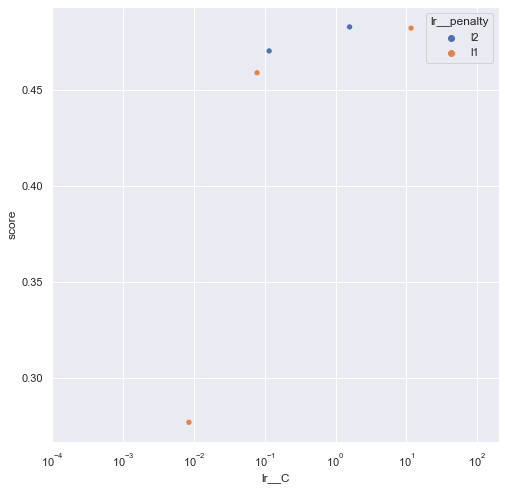

In [36]:
results = df_results(trials.results)
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='lr__C', y='score', hue='lr__penalty', 
                                                   data=results);
ax.set_xscale('log')
ax.set_xlim(1e-4, 2e2)

На графике видно, что Hyperopt почти не исследовал районы, где получались низкие значения F1, а сосредоточился на районе с наибольшими значениями этой метрики.

In [37]:
best_params_lr = space_eval(search_space_lr, best)
best_params_lr['C'] = best_params_lr.pop('lr__C')
best_params_lr['penalty'] = best_params_lr.pop('lr__penalty')
print(best_params_lr)

{'C': 1.5772286792299728, 'penalty': 'l2'}


Теперь обучим модель, используя наилучшие гиперпараметры, на тренировочных данных целиком, а затем выведем показатели метрик F1 и ROC-AUC для тестового набора.

In [38]:
best_model_lr = Pipeline([('transformer', transformer),
                  ('lr', LogisticRegression(random_state=420,
                                            n_jobs=-1, 
                                            solver='liblinear',
                                            **best_params_lr
                                           ))]).fit(X_train, y_train)

C:\Users\atrus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


Для отслеживания наилучшей метрики создадим табличку, которую будем заполнять по ходу исследования.
Расшифровка столбцов:

* 'model_name' - имя модели
* 'f1_train'- F1 на обучащей выборке
* 'f1_test' - F1 на тестовой выборке
* 'roc_auc_train' - ROC-AUC на обучащей выборке
* 'roc_auc_test'- ROC-AUC на тестовой выборке
* 'balanced' - использовалась ли балансировка классов

In [39]:
table_comp = pd.DataFrame(columns=[
                                  'model_name',
                                  'f1_train',
                                  'f1_test',
                                  'roc_auc_train',
                                  'roc_auc_test',
                                  'balanced'])

Для добавления в таблицу данных создадим функцию, которая будет возвращать массив для добавления в таблицу

In [40]:
def add_scores_to_table(model, model_name, if_balanced=False):
    f1_train = f1_score(y_train, model.predict(X_train))
    f1_test = f1_score(y_test, model.predict(X_test))
    roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    return {'model_name':model_name,
          'f1_train':f1_train,
          'f1_test':f1_test,
          'roc_auc_train':roc_train,
          'roc_auc_test':roc_test,
          'balanced':if_balanced}

In [41]:
table_comp = table_comp.append(add_scores_to_table(best_model_lr,
                                                   'Логистическая регрессия'
                                                  ), ignore_index=True)

display(table_comp)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,balanced
0,Логистическая регрессия,0.487,0.516,0.834,0.833,False


### Дерево решений

Будем использовать ту же предобработку и пайплайны, что и в предыдущей модели, только в этом случае зададим другие параметры для поиска.

Создаем модель

In [42]:
model_dtree = Pipeline([('transformer', transformer),
                  ('dtree', DecisionTreeClassifier(random_state=420))])

Сформируем пространство поиска параметров для hyperopt:

In [43]:
skf_n_splits = 10
search_space_dtree = {
                      'dtree__criterion' : hp.choice(
                          label='criterion',
                          options=['gini', 'entropy']
                      ),
                      'dtree__max_depth' : scope.int(hp.quniform(
                          'max_depth', 1, 15, 1)),
                      'dtree__min_samples_split' :  scope.int(hp.quniform(
                          'min_samples_split', 2, 40, 1)),
                      'dtree__min_samples_leaf' :  scope.int(hp.quniform(
                          'min_samples_leaf', 1, 20, 1))
                                                             }


In [44]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_dtree,
                       X_train=X_train,
                       y_train=y_train),
          # пространство поиска гиперпараметров  
            space=search_space_dtree,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=100,
          # куда сохранять историю поиска
            trials=trials,
          # ранняя остановка, если нет прогресса в 5 попытках подряд
            early_stop_fn=no_progress_loss(5),
          # random state
            #rstate=np.random.RandomState(420),
          # progressbar
           show_progressbar=True
        )

 11%|█████▏                                         | 11/100 [00:02<00:21,  4.16trial/s, best loss: 0.4323893724192003]


In [45]:
results = df_results(trials.results)
display(results.head(10))

,loss,dtree__criterion,dtree__max_depth,dtree__min_samples_leaf,dtree__min_samples_split,score
5,0.432,entropy,8,6,23,0.568
3,0.433,entropy,12,18,31,0.567
6,0.437,gini,7,11,3,0.563
0,0.440,gini,7,19,28,0.560
1,0.442,gini,11,12,12,0.558
4,0.464,gini,6,5,19,0.536
2,0.470,entropy,6,18,40,0.530
8,0.470,entropy,2,4,25,0.530
10,0.474,gini,4,2,29,0.526
7,0.493,entropy,3,4,35,0.507


Построим график

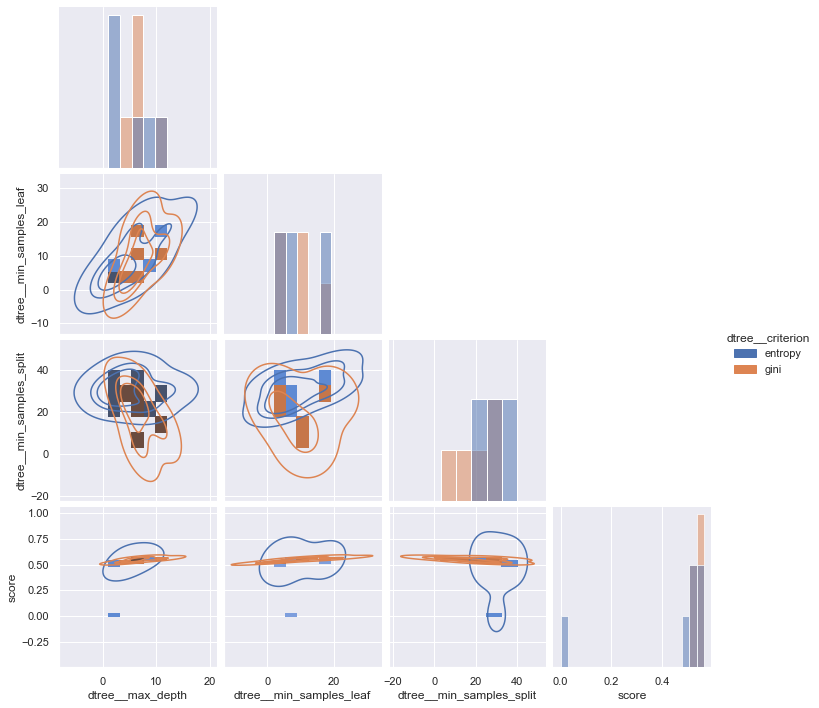

In [46]:
sns.pairplot(results[['dtree__criterion',
                      'dtree__max_depth',
                      'dtree__min_samples_leaf',
                      'dtree__min_samples_split',
                      'score']],
             kind='hist',
             corner=True,
             hue='dtree__criterion'
            ).map_lower(sns.kdeplot, levels=4, color=".2")

Видим, что модель выбирала значения в районе, где была достигнуто наилучшее значение метрики.

Обучим модель с наилучшими параметрами, а затем данные добавим в таблицу


In [47]:
space_eval(search_space_dtree, best)

{'dtree__criterion': 'entropy',
 'dtree__max_depth': 8,
 'dtree__min_samples_leaf': 6,
 'dtree__min_samples_split': 23}

In [48]:
best_params_dtree = space_eval(search_space_dtree, best)
best_params_dtree['criterion'] = best_params_dtree.pop('dtree__criterion')
best_params_dtree['max_depth'] = best_params_dtree.pop('dtree__max_depth')
best_params_dtree['min_samples_leaf'] = best_params_dtree.pop('dtree__min_samples_leaf')
best_params_dtree['min_samples_split'] = best_params_dtree.pop('dtree__min_samples_split')
print(best_params_dtree)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 23}


In [49]:
best_model_dtree = Pipeline([('transformer', transformer),
                  ('dtree', DecisionTreeClassifier(random_state=420,
                                                   **best_params_dtree))]).fit(X_train, y_train)

In [50]:
table_comp = table_comp.append(add_scores_to_table(best_model_dtree, 'Дерево решений'), ignore_index=True)
display(table_comp)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,balanced
0,Логистическая регрессия,0.487,0.516,0.834,0.833,False
1,Дерево решений,0.635,0.571,0.901,0.826,False


Можно заметить, что на тестовой выборке обе метрики для дерева решений хуже, чем на тренировочной. Значит, модель немного переобучена. "Методом перебора" был выявлен оптимальный диапазон глубины `max_depth`, который используется в текущем варианте. То, что модель немного переобучена - нормально. 

### Случайный лес

Действуем по тому же принципу

In [51]:
model_rf = Pipeline([('transformer', transformer),
                  ('rf', RandomForestClassifier(n_jobs=-1, random_state=420))])

Сформируем пространство поиска параметров для hyperopt:

In [52]:
skf_n_splits = 10
search_space_rf = {
                      'rf__criterion' : hp.choice(
                          label='criterion',
                          options=['gini', 'entropy']),
                      'rf__n_estimators' : scope.int(hp.quniform(
                          'n_estimators', 100, 500, 1)),
                      'rf__max_depth' : scope.int(hp.quniform(
                          'max_depth', 1, 10, 1)),
                      'rf__min_samples_split' :  scope.int(hp.quniform(
                          'min_samples_split', 2, 40, 1)),
                      'rf__min_samples_leaf' :  scope.int(hp.quniform(
                          'min_samples_leaf', 1, 20, 1))
}

In [53]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_rf,
                       X_train=X_train,
                       y_train=y_train),
          # пространство поиска гиперпараметров  
            space=search_space_rf,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=50,
          # куда сохранять историю поиска
            trials=trials,
          # ранняя остановка, если нет прогресса в 5 попытках подряд
            early_stop_fn=no_progress_loss(5),
          # random state
            #rstate=np.random.RandomState(420),
          # progressbar
           show_progressbar=True
        )

 22%|██████████▌                                     | 11/50 [01:04<03:48,  5.87s/trial, best loss: 0.4498616395482974]


In [54]:
results = df_results(trials.results)
display(results.head(10))

,loss,rf__criterion,rf__max_depth,rf__min_samples_leaf,rf__min_samples_split,rf__n_estimators,score
5,0.450,entropy,10,6,3,225,0.550
1,0.452,gini,9,5,19,148,0.548
4,0.469,gini,9,18,27,423,0.531
2,0.474,gini,7,10,22,379,0.526
0,0.479,entropy,7,9,15,312,0.521
10,0.480,gini,7,14,37,311,0.520
3,0.516,entropy,6,3,2,181,0.484
9,0.580,entropy,5,10,21,451,0.420
6,0.829,gini,3,13,16,442,0.171
7,0.840,gini,3,6,30,202,0.160


Построим график

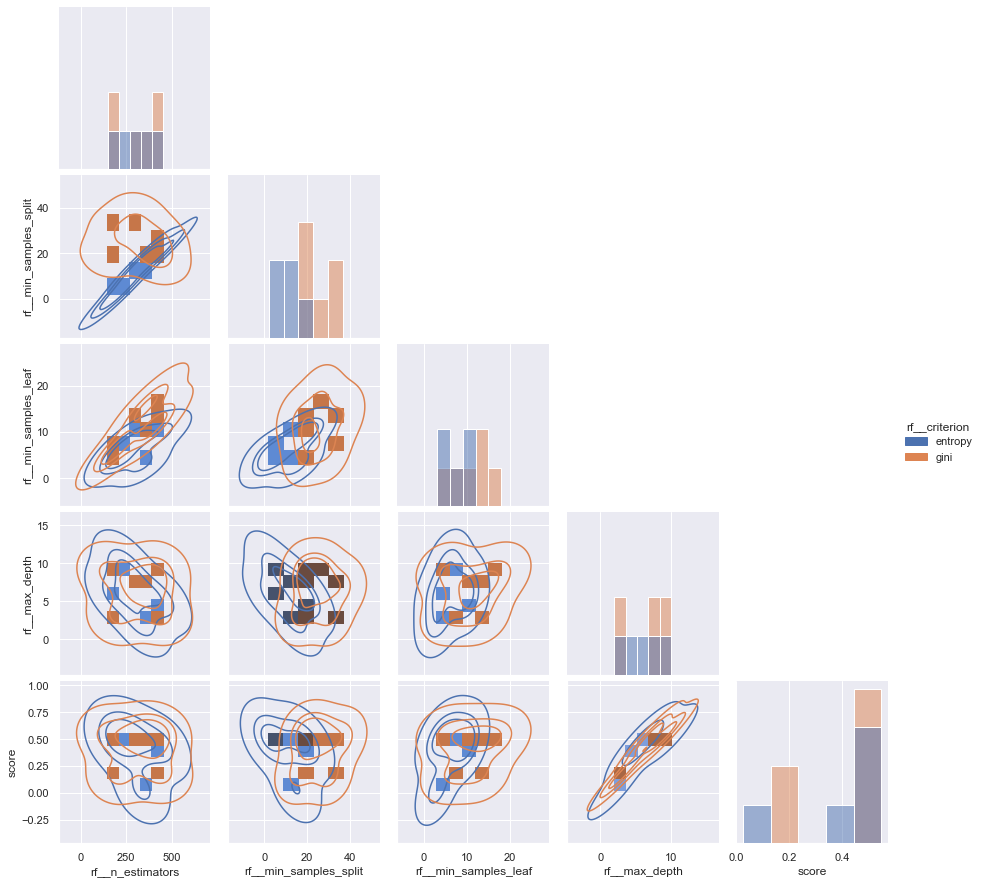

In [55]:
sns.pairplot(results[['rf__n_estimators',
                      'rf__min_samples_split',
                      'rf__min_samples_leaf',
                      'rf__max_depth',
                      'score',
                      'rf__criterion']],
             kind='hist', corner=True, hue='rf__criterion').map_lower(sns.kdeplot, levels=4, color=".2")

Видим, что модель выбирала значения в районе, где была достигнуто наилучшее значение метрики.

Обучим модель с наилучшими параметрами, а затем данные добавим в таблицу

In [56]:
best_params_rf = space_eval(search_space_rf, best)
best_params_rf['criterion'] = best_params_rf.pop('rf__criterion')
best_params_rf['max_depth'] = best_params_rf.pop('rf__max_depth')
best_params_rf['min_samples_leaf'] = best_params_rf.pop('rf__min_samples_leaf')
best_params_rf['min_samples_split'] = best_params_rf.pop('rf__min_samples_split')
best_params_rf['n_estimators'] = best_params_rf.pop('rf__n_estimators')
print(best_params_rf)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 225}


In [57]:
best_model_rf = Pipeline([('transformer', transformer),
                  ('rf', RandomForestClassifier(n_jobs=-1, random_state=420,
                                                   **best_params_rf))]).fit(X_train, y_train)


In [58]:
table_comp = table_comp.append(add_scores_to_table(best_model_rf, 'Случайный лес'), ignore_index=True)
display(table_comp)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,balanced
0,Логистическая регрессия,0.487,0.516,0.834,0.833,False
1,Дерево решений,0.635,0.571,0.901,0.826,False
2,Случайный лес,0.613,0.579,0.923,0.868,False


### Выводы

In [59]:
table_comp.sort_values('f1_test', ascending=False)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,balanced
2,Случайный лес,0.613,0.579,0.923,0.868,False
1,Дерево решений,0.635,0.571,0.901,0.826,False
0,Логистическая регрессия,0.487,0.516,0.834,0.833,False


В данном разделе провели анализ среди моделей машинного обучения без балансировки классов. Наилучшие показатели метрики F1 и ROC-AUC удалось достичь модели случайного леса Выберем эту модель для дальнейшего исследования

## Борьба с дисбалансом

### Подготовка

В данном разделе будем рассматривать три подхода балансировки классов:
1. Downsampling (Undersampling). Понижение размерности выборки. В данном случае будем случайным образом уменьшать majority класс;
2. Upsampling (Over-sampling). Увеличение размерности выборки. В этом - увеличивать случайным образом minority класс;
3. Class weight. Взвешивание классов. Рассмотренные выше модели поддерживают автоматическую балансировку классов за счет взвешивания.

### Взвешивание классов

Самый простой способ - применить автоматическое взвешивание классов в параметрах самой модели.

In [60]:
model_rf_balanced = Pipeline([('transformer', transformer),
                  ('rf', RandomForestClassifier(n_jobs=-1,
                                                random_state=420,
                                                class_weight='balanced'))])

In [61]:
skf_n_splits = 10
search_space_rf_balanced = {
                      'rf__criterion' : hp.choice(
                          label='criterion',
                          options=['gini', 'entropy']),
                      'rf__n_estimators' : scope.int(hp.quniform(
                          'n_estimators', 100, 500, 1)),
                      'rf__max_depth' : scope.int(hp.quniform(
                          'max_depth', 1, 8, 1)),
                      'rf__min_samples_split' :  scope.int(hp.quniform(
                          'min_samples_split', 2, 40, 1)),
                      'rf__min_samples_leaf' :  scope.int(hp.quniform(
                          'min_samples_leaf', 1, 20, 1))
}

In [62]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_rf_balanced,
                       X_train=X_train,
                       y_train=y_train),
          # пространство поиска гиперпараметров  
            space=search_space_rf_balanced,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=50,
          # куда сохранять историю поиска
            trials=trials,
          # ранняя остановка, если нет прогресса в 5 попытках подряд
            early_stop_fn=no_progress_loss(5),
          # random state
            #rstate=np.random.RandomState(420),
          # progressbar
           show_progressbar=True
        )

 14%|██████▊                                          | 7/50 [00:24<02:31,  3.52s/trial, best loss: 0.4059993660660888]


In [63]:
best_params_rf_balanced = space_eval(search_space_rf_balanced, best)
best_params_rf_balanced['criterion'] = best_params_rf_balanced.pop('rf__criterion')
best_params_rf_balanced['max_depth'] = best_params_rf_balanced.pop('rf__max_depth')
best_params_rf_balanced['min_samples_leaf'] = best_params_rf_balanced.pop('rf__min_samples_leaf')
best_params_rf_balanced['min_samples_split'] = best_params_rf_balanced.pop('rf__min_samples_split')
best_params_rf_balanced['n_estimators'] = best_params_rf_balanced.pop('rf__n_estimators')
print(best_params_rf_balanced)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 17, 'min_samples_split': 18, 'n_estimators': 204}


In [64]:
best_model_rf_balanced = Pipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(n_jobs=-1,
                                  random_state=420,
                                  class_weight='balanced',
                                  **best_params_rf_balanced
                                 ))]).fit(X_train, y_train)

In [65]:
table_comp = table_comp.append(
    add_scores_to_table(
        best_model_rf_balanced,
        'Случайный лес "balanced"',
        True
    ), ignore_index=True
)
display(table_comp)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,balanced
0,Логистическая регрессия,0.487,0.516,0.834,0.833,False
1,Дерево решений,0.635,0.571,0.901,0.826,False
2,Случайный лес,0.613,0.579,0.923,0.868,False
3,"Случайный лес ""balanced""",0.611,0.592,0.872,0.857,True


Как видим, показатель метрики F1 увеличился как на обучающей выборке, так и на тестовой, а ROC-AUC почти не изменился

### Upsampling

Данный метод предполагает увеличение меньшего класса для достижения баланса. Все манипуляции будем проводить с обучающей выборкой, а тестовую оставим, как есть.

Во сколько раз необходимо увеличить наименьший класс?

In [66]:
repeat = round(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
print(repeat)

4


Напишем функцию, которая будет принимать датафрейм с признаками, датафрейм с метками, значение, во сколько раз необходимо увеличить данные. Также добавим перемешивание

In [67]:
def upsample_ones(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat(
    [features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat(
    [target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

In [68]:
print(f'Размер до {len(X_train)}')
X_train_up, y_train_up = upsample_ones(X_train, y_train, repeat)
print(f'Размер после {len(X_train_up)}')
print(f'Баланс классов {y_train_up.mean()}')

Размер до 7500
Размер после 12084
Баланс классов 0.5057927838464085


In [69]:
model_rf_up = Pipeline([('transformer', transformer),
                  ('rf', RandomForestClassifier(n_jobs=-1,
                                                random_state=420))])

In [70]:
skf_n_splits = 10
search_space_rf_up = {
                      'rf__criterion' : hp.choice(
                          label='criterion',
                          options=['gini', 'entropy']),
                      'rf__n_estimators' : scope.int(hp.quniform(
                          'n_estimators', 100, 500, 1)),
                      'rf__max_depth' : scope.int(hp.quniform(
                          'max_depth', 1, 8, 1)),
                      'rf__min_samples_split' :  scope.int(hp.quniform(
                          'min_samples_split', 2, 40, 1)),
                      'rf__min_samples_leaf' :  scope.int(hp.quniform(
                          'min_samples_leaf', 1, 20, 1))
}

In [71]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_rf_up,
                       X_train=X_train_up,
                       y_train=y_train_up),
          # пространство поиска гиперпараметров  
            space=search_space_rf_balanced,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=50,
          # куда сохранять историю поиска
            trials=trials,
          # ранняя остановка, если нет прогресса в 5 попытках подряд
            early_stop_fn=no_progress_loss(5),
          # random state
            #rstate=np.random.RandomState(420),
          # progressbar
           show_progressbar=True
        )

 30%|██████████████                                 | 15/50 [01:51<04:20,  7.44s/trial, best loss: 0.20013685918289026]


In [72]:
results = df_results(trials.results)
display(results.head(10))

,loss,rf__criterion,rf__max_depth,rf__min_samples_leaf,rf__min_samples_split,rf__n_estimators,score
9,0.200,entropy,8,8,5,167,0.800
6,0.210,gini,7,15,17,287,0.790
10,0.211,entropy,7,16,39,270,0.789
3,0.215,gini,6,8,21,484,0.785
7,0.215,entropy,6,2,18,453,0.785
1,0.216,gini,6,9,28,119,0.784
14,0.217,entropy,6,13,22,155,0.783
8,0.222,gini,5,3,7,489,0.778
11,0.223,entropy,5,17,30,230,0.777
0,0.227,gini,4,18,23,357,0.773


Можно заметить, что на кросс-валидации при обучении был достигнут показатель метрики F1 со значением 0.80. Это очень неплохой результат!

Но будет ли такой же показатель на тестовой выборке?

In [73]:
best_params_rf_up = space_eval(search_space_rf_up, best)
best_params_rf_up['criterion'] = best_params_rf_up.pop('rf__criterion')
best_params_rf_up['max_depth'] = best_params_rf_up.pop('rf__max_depth')
best_params_rf_up['min_samples_leaf'] = best_params_rf_up.pop('rf__min_samples_leaf')
best_params_rf_up['min_samples_split'] = best_params_rf_up.pop('rf__min_samples_split')
best_params_rf_up['n_estimators'] = best_params_rf_up.pop('rf__n_estimators')
print(best_params_rf_up)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 167}


In [74]:
best_model_rf_up = Pipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(n_jobs=-1,
                                  random_state=420,
                                  **best_params_rf_up
                                 ))]).fit(X_train_up, y_train_up)

In [75]:
table_comp = table_comp.append(
    add_scores_to_table(
        best_model_rf_up,
        'Случайный лес "upsampling"',
        True
    ), ignore_index=True
)
display(table_comp)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,balanced
0,Логистическая регрессия,0.487,0.516,0.834,0.833,False
1,Дерево решений,0.635,0.571,0.901,0.826,False
2,Случайный лес,0.613,0.579,0.923,0.868,False
3,"Случайный лес ""balanced""",0.611,0.592,0.872,0.857,True
4,"Случайный лес ""upsampling""",0.640,0.593,0.902,0.864,True


Получается, что несмотря на то, что при обучении на кросс-валидации был достигнут высокий показатель метрики F1, обученная модель на тестовой выборке показала почти такие же результаты, как и в случае с автоматическим взвешиванием.

Интересно, улучшилась бы ситуация, если бы мы еще дополнительно балансировали классы признаков?

### Downsampling

В этом разделе будем производить понижение размерности выборки. Предположительно это плохо скажется на обучении модели, так как изначально выборка небольшого размера. Наверное, придется снизить количество фолдов на кросс-валидации

Во сколько необходимо уменьшить наибольший класс, чтобы добиться баланса?

In [76]:
len(y_train[y_train == 0]) / len(y_train[y_train == 1])

3.9083769633507854

Во столько же, во сколько необходимо было увеличить меньший класс!

Какова доля меньшего класса в большем по размерности?

In [77]:
fraction = len(y_train[y_train == 1]) / len(y_train[y_train == 0])
print(fraction)

0.25586068318821165


In [78]:
def downsample_zeros(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
    [features_zeros.sample(frac=fraction, random_state=42)]
    + [features_ones])
    target_downsampled = pd.concat(
    [target_zeros.sample(frac=fraction, random_state=42)]
    + [target_ones])
    return features_downsampled, target_downsampled

In [79]:
print(f'Размер до {len(X_train)}')
X_train_down, y_train_down = downsample_zeros(X_train, y_train, fraction)
print(f'Размер после {len(X_train_down)}')
print(f'Баланс классов {y_train_down.mean()}')

Размер до 7500
Размер после 3056
Баланс классов 0.5


Получилась выборка с тремя тысячами значений. Если проводить кросс-валидацию на 10 фолдах, то на целевой признак при перекрестной проверке придется всего около 300 значений. Будем пробовать!

In [80]:
model_rf_down = Pipeline([('transformer', transformer),
                  ('rf', RandomForestClassifier(n_jobs=-1,
                                                random_state=420))])

In [81]:
skf_n_splits = 10
search_space_rf_down = {
                      'rf__criterion' : hp.choice(
                          label='criterion',
                          options=['gini', 'entropy']),
                      'rf__n_estimators' : scope.int(hp.quniform(
                          'n_estimators', 100, 500, 1)),
                      'rf__max_depth' : scope.int(hp.quniform(
                          'max_depth', 1, 8, 1)),
                      'rf__min_samples_split' :  scope.int(hp.quniform(
                          'min_samples_split', 2, 40, 1)),
                      'rf__min_samples_leaf' :  scope.int(hp.quniform(
                          'min_samples_leaf', 1, 20, 1))
}

In [82]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_rf_down,
                       X_train=X_train_down,
                       y_train=y_train_down),
          # пространство поиска гиперпараметров  
            space=search_space_rf_down,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=50,
          # куда сохранять историю поиска
            trials=trials,
          # ранняя остановка, если нет прогресса в 5 попытках подряд
            early_stop_fn=no_progress_loss(5),
          # random state
            #rstate=np.random.RandomState(420),
          # progressbar
           show_progressbar=True
        )

 18%|████████▊                                        | 9/50 [00:27<02:05,  3.05s/trial, best loss: 0.2348253217800378]


In [83]:
results = df_results(trials.results)
display(results.head(10))

,loss,rf__criterion,rf__max_depth,rf__min_samples_leaf,rf__min_samples_split,rf__n_estimators,score
3,0.235,entropy,5,20,16,140,0.765
5,0.235,entropy,8,2,17,141,0.765
2,0.236,gini,6,19,39,454,0.764
1,0.237,entropy,7,5,36,122,0.763
8,0.237,gini,5,1,29,315,0.763
6,0.241,gini,4,12,16,419,0.759
0,0.241,gini,5,3,4,389,0.759
4,0.243,entropy,4,13,4,340,0.757
7,0.246,gini,3,1,4,210,0.754


Можно заметить, что на кросс-валидации при обучении был достигнут показатель метрики F1 со значением 0.80. Это очень неплохой результат!

Но будет ли такой же показатель на тестовой выборке?

In [84]:
best_params_rf_down = space_eval(search_space_rf_down, best)
best_params_rf_down['criterion'] = best_params_rf_down.pop('rf__criterion')
best_params_rf_down['max_depth'] = best_params_rf_down.pop('rf__max_depth')
best_params_rf_down['min_samples_leaf'] = best_params_rf_down.pop('rf__min_samples_leaf')
best_params_rf_down['min_samples_split'] = best_params_rf_down.pop('rf__min_samples_split')
best_params_rf_down['n_estimators'] = best_params_rf_down.pop('rf__n_estimators')
print(best_params_rf_down)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 16, 'n_estimators': 140}


In [85]:
best_model_rf_down = Pipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(n_jobs=-1,
                                  random_state=420,
                                  **best_params_rf_down
                                 ))]).fit(X_train_down, y_train_down)

In [86]:
table_comp = table_comp.append(
    add_scores_to_table(
        best_model_rf_down,
        'Случайный лес "downsampling"',
        True
    ), ignore_index=True
)
display(table_comp)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,balanced
0,Логистическая регрессия,0.487,0.516,0.834,0.833,False
1,Дерево решений,0.635,0.571,0.901,0.826,False
2,Случайный лес,0.613,0.579,0.923,0.868,False
3,"Случайный лес ""balanced""",0.611,0.592,0.872,0.857,True
4,"Случайный лес ""upsampling""",0.640,0.593,0.902,0.864,True
5,"Случайный лес ""downsampling""",0.594,0.581,0.859,0.853,True


### Выводы

В данном разделе провели исследование балансировки целевого признака следующими методами:
* Взвешивание классов в параметрах самой модели;
* Увеличение выборки;
* Уменьшение выборки.

В таблице ниже видно, что наилучший показатель метрики F1 на тестовой выборке был достигнут с помощью взвешивания в параметрах самой модели, хотя остальные методы не сильно отстают.

Также можно заметить, что показатель метрики ROC-AUC на тестовой выборке в этих случаях одинаковый при всех подходах.

In [87]:
table_comp[table_comp['balanced'] == True
          ].sort_values('f1_test', ascending=False)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,balanced
4,"Случайный лес ""upsampling""",0.640,0.593,0.902,0.864,True
3,"Случайный лес ""balanced""",0.611,0.592,0.872,0.857,True
5,"Случайный лес ""downsampling""",0.594,0.581,0.859,0.853,True


## Общие выводы

На основании проделанной работы можно сделать вывод о том, что разные подходы балансировки классов целевого признака дают схожие результаты.

При этом наименее трудозатратным является метод взвешивания классов, так как в этом случае нет необходимости проводить дополнительные манипуляции с данными.

В таблице ниже видно, что для метрики ROC-AUC баланс классов не критичен в отличие от F-меры

In [88]:
table_comp

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,balanced
0,Логистическая регрессия,0.487,0.516,0.834,0.833,False
1,Дерево решений,0.635,0.571,0.901,0.826,False
2,Случайный лес,0.613,0.579,0.923,0.868,False
3,"Случайный лес ""balanced""",0.611,0.592,0.872,0.857,True
4,"Случайный лес ""upsampling""",0.640,0.593,0.902,0.864,True
5,"Случайный лес ""downsampling""",0.594,0.581,0.859,0.853,True


Первоначальное сравнение проводили среди следующих алгоритмов машинного обучения:
* Логистическая регрессия;
* Дерево решений;
* Случайный лес.

Наилучший показатель метрики F-меры на тестовой выборке без учета балансировки классов был получен с помощью модели случайного леса. Далее этот алгоритм был выбран для проверки разных подходов балансировки классов целевого признака. Были выбраны следующие методы:
* Взвешивание классов в параметрах самой модели;
* Увеличение выборки;
* Уменьшение выборки.

С помощью этих подходов были получены схожие результаты. Если учитывать показатели метрики F-меры, то модель с учетом балансировки (не важно каким методом) делает прогнозы лучше, чем без учета балансировки. На метрику ROC-AUC балансировка не повлияла.

С учетом проведенного исследования можно сделать заключительный вывод о том, что любой метод балансировки классов целевого признака эффективен. Наиболее оптимально использовать взвешивание классов, так как данный метод нетрудозатратен, и в данной работе дал наилучший прирост метрики F1